In [1]:
# Complete ELT Pipeline Tutorial - Google Colab
# 🚀 Build Your First Data Warehouse in 30 Minutes!

# ============================================================================
# STEP 1: SETUP & AUTHENTICATION
# ============================================================================

# Install required packages
!pip install google-cloud-bigquery pandas matplotlib seaborn plotly

# Import libraries
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.colab import auth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import random

# Authenticate with Google Cloud
print("🔐 Authenticating with Google Cloud...")
auth.authenticate_user()
print("✅ Authentication complete!")

🔐 Authenticating with Google Cloud...
✅ Authentication complete!


In [2]:
# STEP 2: CREATE SAMPLE E-COMMERCE DATA (EXTRACT)
# ============================================================================

print("\n📊 Generating sample e-commerce data...")

# Set random seed for reproducible data
np.random.seed(42)
random.seed(42)

# Generate sample customers data
customers = []
customer_ids = range(1, 1001)  # 1000 customers
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia']
segments = ['Premium', 'Standard', 'Basic']

for customer_id in customer_ids:
    customers.append({
        'customer_id': customer_id,
        'customer_name': f'Customer_{customer_id}',
        'city': random.choice(cities),
        'segment': random.choice(segments),
        'signup_date': datetime(2023, 1, 1) + timedelta(days=random.randint(0, 365))
    })

customers_df = pd.DataFrame(customers)

# Generate sample products data
products = []
categories = ['Electronics', 'Clothing', 'Home', 'Books', 'Sports']
for product_id in range(1, 101):  # 100 products
    products.append({
        'product_id': product_id,
        'product_name': f'Product_{product_id}',
        'category': random.choice(categories),
        'unit_price': round(random.uniform(10, 500), 2)
    })

products_df = pd.DataFrame(products)

# Generate sample orders data
orders = []
order_id = 1
for _ in range(5000):  # 5000 orders
    customer_id = random.choice(customer_ids)
    product_id = random.randint(1, 100)
    quantity = random.randint(1, 5)
    order_date = datetime(2023, 1, 1) + timedelta(days=random.randint(0, 365))

    orders.append({
        'order_id': order_id,
        'customer_id': customer_id,
        'product_id': product_id,
        'quantity': quantity,
        'order_date': order_date
    })
    order_id += 1

orders_df = pd.DataFrame(orders)

print(f"✅ Generated sample data:")
print(f"   📋 Customers: {len(customers_df)} records")
print(f"   🛍️ Products: {len(products_df)} records")
print(f"   📦 Orders: {len(orders_df)} records")

# Preview the data
print("\n👀 Sample data preview:")
print("\nCustomers:")
print(customers_df.head())
print("\nProducts:")
print(products_df.head())
print("\nOrders:")
print(orders_df.head())



📊 Generating sample e-commerce data...
✅ Generated sample data:
   📋 Customers: 1000 records
   🛍️ Products: 100 records
   📦 Orders: 5000 records

👀 Sample data preview:

Customers:
   customer_id customer_name          city   segment signup_date
0            1    Customer_1  Philadelphia   Premium  2023-01-13
1            2    Customer_2  Philadelphia  Standard  2023-05-06
2            3    Customer_3   Los Angeles   Premium  2023-02-22
3            4    Customer_4  Philadelphia     Basic  2023-10-07
4            5    Customer_5      New York     Basic  2023-08-05

Products:
   product_id product_name     category  unit_price
0           1    Product_1     Clothing      404.83
1           2    Product_2  Electronics      285.57
2           3    Product_3        Books      283.07
3           4    Product_4     Clothing      200.33
4           5    Product_5         Home      109.63

Orders:
   order_id  customer_id  product_id  quantity order_date
0         1          365          71

In [3]:
# STEP 3: SETUP BIGQUERY (LOAD)
# ============================================================================

print("\n🏗️ Setting up BigQuery...")

# Set your Google Cloud project ID
PROJECT_ID = input("Enter your Google Cloud Project ID: ")

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# Create dataset
DATASET_ID = 'ecommerce_elt_demo'
dataset_id = f"{PROJECT_ID}.{DATASET_ID}"

# Create dataset if it doesn't exist
try:
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = "US"
    dataset = client.create_dataset(dataset, exists_ok=True)
    print(f"✅ Dataset {DATASET_ID} created/verified")
except Exception as e:
    print(f"❌ Error creating dataset: {e}")



🏗️ Setting up BigQuery...
Enter your Google Cloud Project ID: rapid-bricolage-461421-b9
✅ Dataset ecommerce_elt_demo created/verified


In [4]:
# STEP 4: LOAD RAW DATA TO BIGQUERY
# ============================================================================

print("\n📤 Loading raw data to BigQuery...")

def load_dataframe_to_bigquery(df, table_name, dataset_id):
    """Load pandas dataframe to BigQuery"""
    table_id = f"{dataset_id}.{table_name}"

    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE",  # Overwrite table
        autodetect=True  # Auto-detect schema
    )

    job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
    job.result()  # Wait for job to complete

    table = client.get_table(table_id)
    print(f"✅ Loaded {table.num_rows} rows to {table_name}")

# Load all tables
load_dataframe_to_bigquery(customers_df, 'raw_customers', dataset_id)
load_dataframe_to_bigquery(products_df, 'raw_products', dataset_id)
load_dataframe_to_bigquery(orders_df, 'raw_orders', dataset_id)

print("🎉 All raw data loaded to BigQuery!")



📤 Loading raw data to BigQuery...
✅ Loaded 1000 rows to raw_customers
✅ Loaded 100 rows to raw_products
✅ Loaded 5000 rows to raw_orders
🎉 All raw data loaded to BigQuery!


In [5]:
# ============================================================================
# STEP 5: TRANSFORM DATA (SQL Transformations)
# ============================================================================

print("\n🔧 Starting data transformations...")

# Transformation 1: Create customer dimension
customer_dim_query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.dim_customers` AS
SELECT
    customer_id,
    customer_name,
    city,
    segment,
    signup_date,
    CASE
        WHEN segment = 'Premium' THEN 'High Value'
        WHEN segment = 'Standard' THEN 'Medium Value'
        ELSE 'Low Value'
    END as value_tier
FROM `{dataset_id}.raw_customers`
"""

# Transformation 2: Create product dimension
product_dim_query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.dim_products` AS
SELECT
    product_id,
    product_name,
    category,
    unit_price,
    CASE
        WHEN unit_price >= 200 THEN 'Premium'
        WHEN unit_price >= 50 THEN 'Mid-Range'
        ELSE 'Budget'
    END as price_tier
FROM `{dataset_id}.raw_products`
"""

# Transformation 3: Create sales fact table
sales_fact_query = f"""
CREATE OR REPLACE TABLE `{dataset_id}.fact_sales` AS
SELECT
    o.order_id,
    o.customer_id,
    o.product_id,
    o.quantity,
    o.order_date,
    p.unit_price,
    (o.quantity * p.unit_price) as total_amount,
    EXTRACT(YEAR FROM o.order_date) as order_year,
    EXTRACT(MONTH FROM o.order_date) as order_month,
    FORMAT_DATE('%Y-%m', o.order_date) as year_month
FROM `{dataset_id}.raw_orders` o
JOIN `{dataset_id}.raw_products` p ON o.product_id = p.product_id
"""

# Execute transformations
transformations = [
    ("Customer Dimension", customer_dim_query),
    ("Product Dimension", product_dim_query),
    ("Sales Fact Table", sales_fact_query)
]

for name, query in transformations:
    print(f"🔄 Creating {name}...")
    job = client.query(query)
    job.result()
    print(f"✅ {name} created successfully")

print("🎉 All transformations completed!")



🔧 Starting data transformations...
🔄 Creating Customer Dimension...
✅ Customer Dimension created successfully
🔄 Creating Product Dimension...
✅ Product Dimension created successfully
🔄 Creating Sales Fact Table...
✅ Sales Fact Table created successfully
🎉 All transformations completed!


In [7]:
# STEP 6: CREATE BUSINESS ANALYTICS VIEWS
# ============================================================================

print("\n📊 Creating business analytics views...")

# Monthly sales summary
monthly_sales_query = f"""
CREATE OR REPLACE VIEW `{dataset_id}.monthly_sales_summary` AS
SELECT
    year_month,
    COUNT(DISTINCT order_id) as total_orders,
    COUNT(DISTINCT customer_id) as unique_customers,
    SUM(quantity) as total_items_sold,
    ROUND(SUM(total_amount), 2) as total_revenue,
    ROUND(AVG(total_amount), 2) as avg_order_value
FROM `{dataset_id}.fact_sales`
GROUP BY year_month
ORDER BY year_month
"""

# Customer segment analysis
customer_analysis_query = f"""
CREATE OR REPLACE VIEW `{dataset_id}.customer_segment_analysis` AS
SELECT
    c.segment,
    c.value_tier,
    COUNT(DISTINCT c.customer_id) as customer_count,
    COUNT(DISTINCT s.order_id) as total_orders,
    ROUND(SUM(s.total_amount), 2) as total_revenue,
    ROUND(AVG(s.total_amount), 2) as avg_order_value,
    ROUND(SUM(s.total_amount) / COUNT(DISTINCT c.customer_id), 2) as revenue_per_customer
FROM `{dataset_id}.dim_customers` c
LEFT JOIN `{dataset_id}.fact_sales` s ON c.customer_id = s.customer_id
GROUP BY c.segment, c.value_tier
ORDER BY total_revenue DESC
"""

# Product category performance
category_performance_query = f"""
CREATE OR REPLACE VIEW `{dataset_id}.category_performance` AS
SELECT
    p.category,
    p.price_tier,
    COUNT(DISTINCT s.order_id) as total_orders,
    SUM(s.quantity) as total_quantity_sold,
    ROUND(SUM(s.total_amount), 2) as total_revenue,
    ROUND(AVG(s.total_amount), 2) as avg_order_value
FROM `{dataset_id}.dim_products` p
LEFT JOIN `{dataset_id}.fact_sales` s ON p.product_id = s.product_id
GROUP BY p.category, p.price_tier
ORDER BY total_revenue DESC
"""

# Execute analytics views
analytics_views = [
    ("Monthly Sales Summary", monthly_sales_query),
    ("Customer Segment Analysis", customer_analysis_query),
    ("Category Performance", category_performance_query)
]

for name, query in analytics_views:
    print(f"🔄 Creating {name}...")
    job = client.query(query)
    job.result()
    print(f"✅ {name} created successfully")


📊 Creating business analytics views...
🔄 Creating Monthly Sales Summary...
✅ Monthly Sales Summary created successfully
🔄 Creating Customer Segment Analysis...
✅ Customer Segment Analysis created successfully
🔄 Creating Category Performance...
✅ Category Performance created successfully



📈 Creating visualizations...


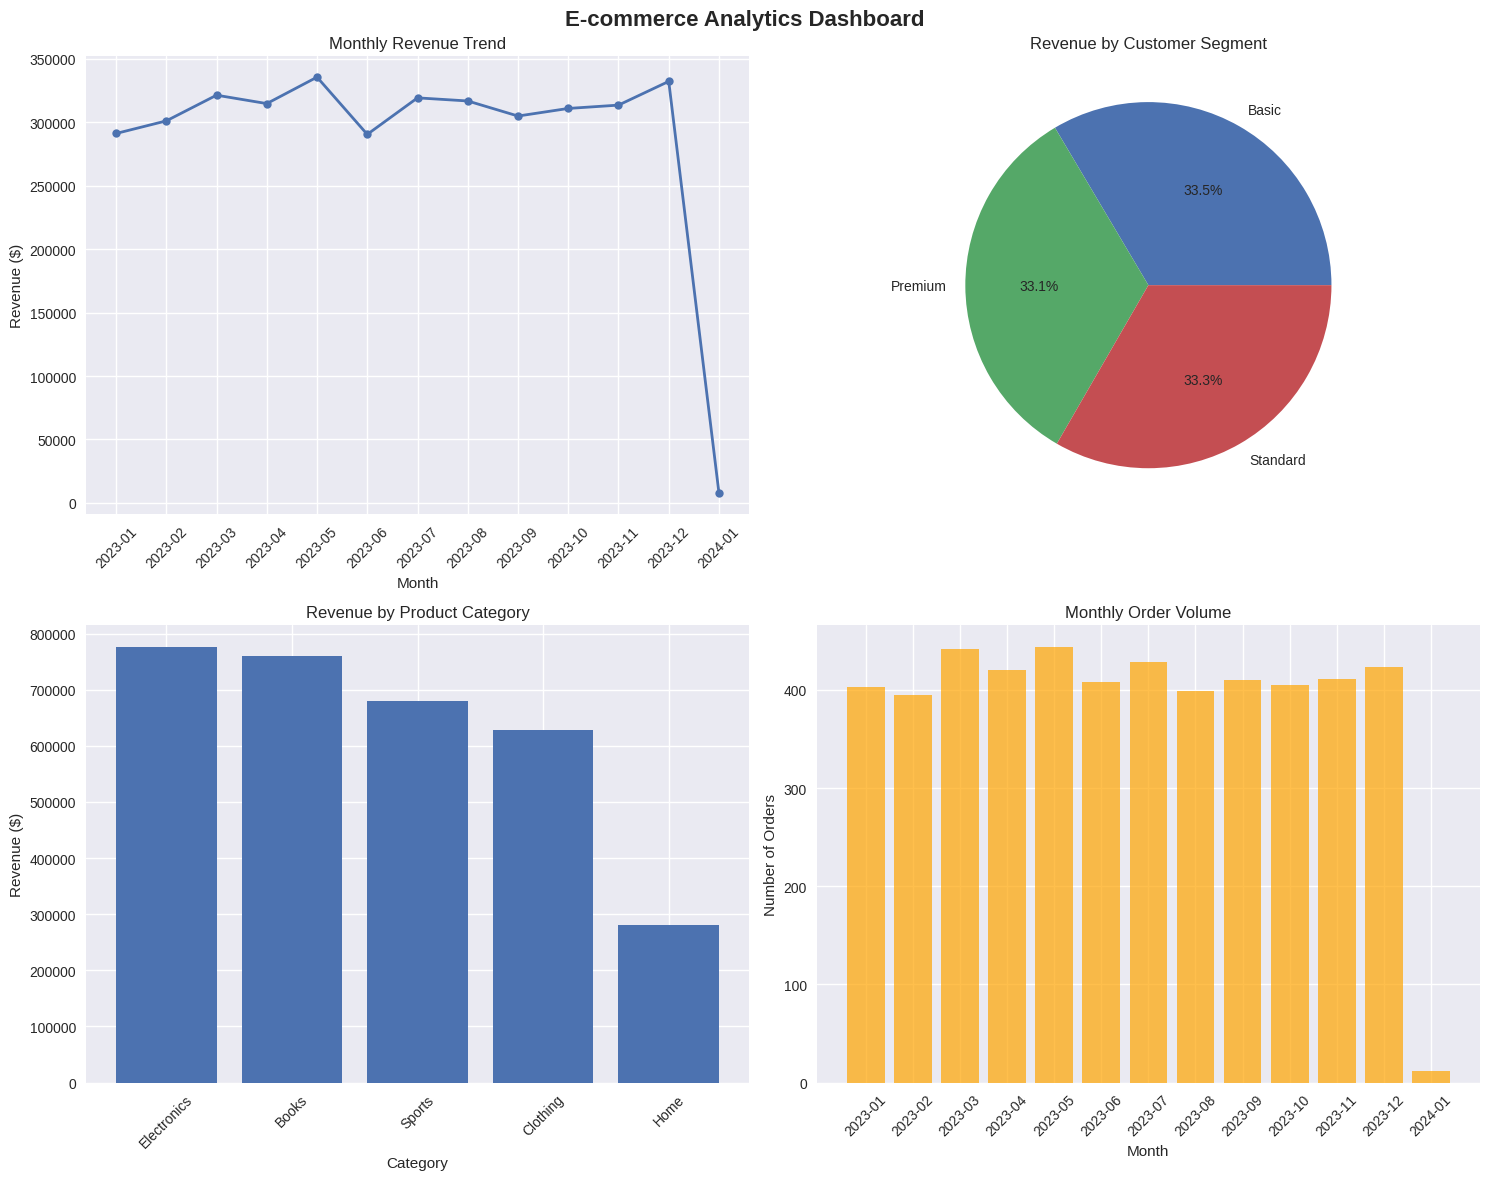

In [8]:
# ============================================================================
# STEP 7: ANALYZE DATA & CREATE VISUALIZATIONS
# ============================================================================

print("\n📈 Creating visualizations...")

# Query monthly sales data
monthly_sales_df = client.query(f"""
SELECT * FROM `{dataset_id}.monthly_sales_summary`
ORDER BY year_month
""").to_dataframe()

# Query customer segment data
customer_segment_df = client.query(f"""
SELECT * FROM `{dataset_id}.customer_segment_analysis`
""").to_dataframe()

# Query category performance data
category_performance_df = client.query(f"""
SELECT * FROM `{dataset_id}.category_performance`
""").to_dataframe()

# Create visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('E-commerce Analytics Dashboard', fontsize=16, fontweight='bold')

# 1. Monthly Revenue Trend
axes[0,0].plot(monthly_sales_df['year_month'], monthly_sales_df['total_revenue'],
               marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('Monthly Revenue Trend')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Customer Segment Revenue
segment_revenue = customer_segment_df.groupby('segment')['total_revenue'].sum()
axes[0,1].pie(segment_revenue.values, labels=segment_revenue.index, autopct='%1.1f%%')
axes[0,1].set_title('Revenue by Customer Segment')

# 3. Category Performance
axes[1,0].bar(category_performance_df['category'],
              category_performance_df['total_revenue'])
axes[1,0].set_title('Revenue by Product Category')
axes[1,0].set_xlabel('Category')
axes[1,0].set_ylabel('Revenue ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Monthly Orders
axes[1,1].bar(monthly_sales_df['year_month'], monthly_sales_df['total_orders'],
              color='orange', alpha=0.7)
axes[1,1].set_title('Monthly Order Volume')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Number of Orders')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# STEP 8: SUMMARY & NEXT STEPS
# ============================================================================

print("\n🎉 CONGRATULATIONS! Your ELT Pipeline is Complete!")
print("="*60)

# Calculate summary statistics
total_revenue = monthly_sales_df['total_revenue'].sum()
total_orders = monthly_sales_df['total_orders'].sum()
avg_monthly_revenue = monthly_sales_df['total_revenue'].mean()

print(f"📊 BUSINESS INSIGHTS:")
print(f"   💰 Total Revenue: ${total_revenue:,.2f}")
print(f"   📦 Total Orders: {total_orders:,}")
print(f"   📈 Average Monthly Revenue: ${avg_monthly_revenue:,.2f}")
print(f"   🏆 Top Category: {category_performance_df.iloc[0]['category']}")
print(f"   👑 Best Segment: {customer_segment_df.iloc[0]['segment']}")

print(f"\n🎯 WHAT YOU'VE BUILT:")
print("   ✅ Complete ELT pipeline")
print("   ✅ Data warehouse with star schema")
print("   ✅ Automated transformations")
print("   ✅ Business analytics views")
print("   ✅ Interactive visualizations")

print(f"\n🚀 NEXT STEPS:")
print("   1. Connect a BI tool (Looker Studio is free with Google)")
print("   2. Add more data sources (APIs, CSV uploads)")
print("   3. Schedule this pipeline to run automatically")
print("   4. Add data quality checks")
print("   5. Implement incremental loading")

print(f"\n📚 RESOURCES TO EXPLORE:")
print("   • BigQuery documentation: https://cloud.google.com/bigquery/docs")
print("   • dbt (data build tool): https://www.getdbt.com/")
print("   • Apache Airflow for orchestration")
print("   • Looker Studio for dashboards")

print("\n" + "="*60)
print("🎊 You're now a data engineer! Keep building! 🎊")


🎉 CONGRATULATIONS! Your ELT Pipeline is Complete!
📊 BUSINESS INSIGHTS:
   💰 Total Revenue: $3,759,638.70
   📦 Total Orders: 5,000
   📈 Average Monthly Revenue: $289,202.98
   🏆 Top Category: Electronics
   👑 Best Segment: Basic

🎯 WHAT YOU'VE BUILT:
   ✅ Complete ELT pipeline
   ✅ Data warehouse with star schema
   ✅ Automated transformations
   ✅ Business analytics views
   ✅ Interactive visualizations

🚀 NEXT STEPS:
   1. Connect a BI tool (Looker Studio is free with Google)
   2. Add more data sources (APIs, CSV uploads)
   3. Schedule this pipeline to run automatically
   4. Add data quality checks
   5. Implement incremental loading

📚 RESOURCES TO EXPLORE:
   • BigQuery documentation: https://cloud.google.com/bigquery/docs
   • dbt (data build tool): https://www.getdbt.com/
   • Apache Airflow for orchestration
   • Looker Studio for dashboards

🎊 You're now a data engineer! Keep building! 🎊
